# Understand how the heating/cooling changes with time
Local thermal time is estimated by the **instantaneous** heating/cooling rates. But it needs not mean the heating / cooling would persist within the fluid cell element throughtout the hydro-timestep. 

Here we take a snapshot of the simulation, evolve it over the freefall time with dengo, and see which part of the phase space changes from heating to cooling through time.

In [1]:
%load_ext autoreload
%autoreload 2
import yt
import matplotlib.pyplot as plt
from utils import load_grackle_dataset, load_dengo_dataset
from plot_utils import plot_multi_sliceplot

/home/kwoksun2/anaconda3/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/kwoksun2/.config/yt/ytrc is deprecated in favor of /home/kwoksun2/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


 ChiantiPy version 0.12.0 
 found PyQt5 widgets
 using PyQt5 widgets


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/tools/data.py:71: UserWarning: klgfb files are not present: 
  it will not be possible to use the freeBound continuum method
  warnings.warn('klgfb files are not present: \n  it will not be possible to use the freeBound continuum method')
/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


## Load the Dataset

In [2]:
dengo_snap = "/home/kwoksun2/data/campus_cluster/bechem_z100_baryon_re3/DD0070/DD0070"
grackle_snap = "/home/kwoksun2/data/campus_cluster/grackle_z100_baryon/DD0072/DD0072"
dengo_ds = load_dengo_dataset(dengo_snap)
grackle_ds = load_grackle_dataset(grackle_snap)

yt : [INFO     ] 2022-09-12 13:59:34,053 Parameters: current_time              = 11.301308754354
yt : [INFO     ] 2022-09-12 13:59:34,055 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2022-09-12 13:59:34,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 13:59:34,058 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 13:59:34,059 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-09-12 13:59:34,060 Parameters: current_redshift          = 16.51946269887
yt : [INFO     ] 2022-09-12 13:59:34,060 Parameters: omega_lambda              = 0.724
yt : [INFO     ] 2022-09-12 13:59:34,061 Parameters: omega_matter              = 0.276
yt : [INFO     ] 2022-09-12 13:59:34,062 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-09-12 13:59:34,063 Parameters: hubble_constant           = 0.703
Parsing Hierarchy : 100%|██████████████████████████████████████████████████| 22287/22287 [00:03<00:00

## Prepare the inputs to the rate calculations
- Extract a sphere around the densest cell
- Flatten it and feed it to Dengo
- Evolve for some time
- And monitor how the heating/ cooling rate changes

In [4]:
sp_dengo_1000AU = dengo_ds.sphere(center="m", radius=(500, "au"))

yt : [INFO     ] 2022-09-12 14:15:48,045 max value is 1.42583e-10 at 0.4980584005315905 0.5005448366355267 0.4986057875721599


In [5]:
map_to_dengo = {
    "H2I_Density": "H2_1",
    "H2II_Density": "H2_2",
    "HI_Density": "H_1",
    "HII_Density": "H_2",
    "HM_Density": "H_m0",
    "HeI_Density": "He_1",
    "HeII_Density": "He_2",
    "HeIII_Density": "He_3",
    "Electron_Density": "de",
    "specific_thermal_energy": "ge",
    "density": "density",
}

# nsamples = f['grid'].attrs['num_elements']

start = 0
init_values = {}
for fname, name in map_to_dengo.items():
    if name not in ["ge"]:
        init_values[name] = sp_dengo_1000AU[fname][::100].v / 1.67e-24
    else:
        init_values[name] = sp_dengo_1000AU[fname][::100].v
        print(init_values[name])

[9.11503114e+10 8.05683164e+10 9.64057861e+10 ... 1.08000306e+11
 1.17657689e+11 1.28965414e+11]


## Prepare the Dengo Solver

In [6]:
import sympy
from sympy import lambdify
from dengo.chemical_network import (
    ChemicalNetwork,
    reaction_registry,
    cooling_registry,
    species_registry,
)

import dengo.primordial_rates
import dengo.primordial_cooling

from dengo.chemical_network import ChemicalNetwork
import pyximport
import numpy as np

cn = ChemicalNetwork()


dengo.primordial_rates.setup_primordial()

for r in reaction_registry:
    if r not in ["k21", "k23"]:
        cn.add_reaction(r)

for c in cooling_registry:
    if c not in ["gammah", "h2formation_extra"]:
        cn.add_cooling(c)

cn.init_temperature((1e0, 1e8))

cn.enforce_conservation = True
cn.set_equilibrium_species("H2_2")

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k22 : 2*H_1 

In [7]:
# write the template solver
solver_name = "simpleNetwork"
cn.write_solver(
    solver_name,
    output_dir=".",
    solver_template="cv_omp/sundials_CVDls",
    ode_solver_source="initialize_cvode_solver.C",
)
# load the imports
pyximport.install(
    setup_args={"include_dirs": np.get_include()},
    reload_support=True,
    inplace=True,
    language_level=3,
)

simple_solver_run = pyximport.load_module(
    f"{solver_name}_solver_run",
    f"{solver_name}_solver_run.pyx",
    build_inplace=True,
    pyxbuild_dir="_dengo_temp",
)

You have suitesparse!


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/gv0/homes/kwoksun2/campus_cluster/reports/simpleNetwork_solver_run.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++


## Evolve the Central sphere for 12 year
- snapshot of the innermost 500 AU sphere is selected with yt.
- the system is evolved for ~ 12.6 year. This corresponds to roughly the dynamical timescale of the densest cell $\rho \sim 10^{-10} \mathrm{g ~ cm^{-3}}$ in the current snapshot.
- we also collect the log-spaced trajectory of the chemical evolution for each cell considered.
- the trajectories are used to determine the instaneous cooling/ heating rates.
- be patient this might take a while to run...

In [8]:
density = np.copy(init_values["density"])
tff = (density.max() * 6.67e-8 * 1.67e-24) ** -0.5
rv, rv_int = simple_solver_run.run_simpleNetwork(init_values, tff, niter=100)

Successful iteration[    0]: (3.953e+06) 3.953e+06 / 3.953e+08
End in 26 iterations: 3.95340e+08 / 3.95340e+08 (0.00000e+00)


In [16]:
from utils import get_gammaH2, calculate_temperature_from_dict
from utils import evaluate_cooling_terms, calculate_instant_cooling_rates
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

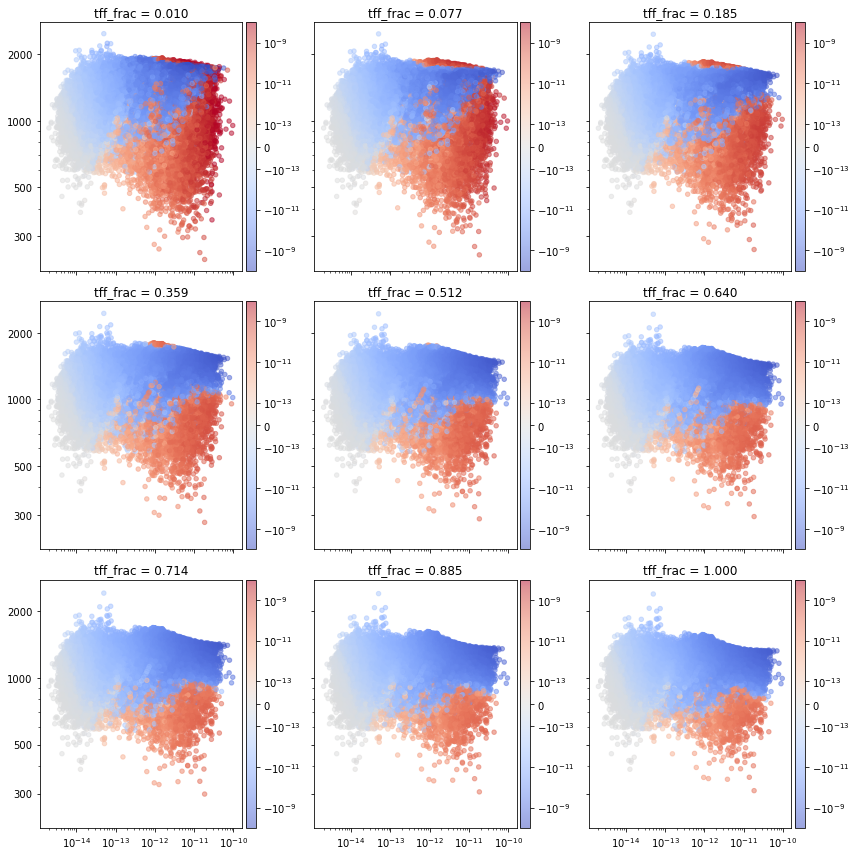

In [48]:
f, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

count = 0
for i in [0, 5, 10, 15, 18, 20, 21, 23, 25]:

    all_rates = calculate_instant_cooling_rates(rv_int, density, tidx=i)

    axes.flat[count].set_title(f"tff_frac = {rv_int['t'][i]/tff:.3f}")
    im = axes.flat[count].scatter(
        density * 1.67e-24,
        all_rates["T"],
        c=all_rates["chemical"],
        norm=SymLogNorm(linthresh=1e-13, vmin=-1e-8, vmax=1e-8),
        cmap="coolwarm",
        #     xscale='log',
        s=20.0,
        alpha=0.5,
    )
    axes.flat[count].set_yscale("log")
    axes.flat[count].set_xscale("log")

    divider = make_axes_locatable(axes.flat[count])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im, cax=cax, orientation="vertical")

    axes.flat[count].set_yticks([300, 500, 1000, 2000], labels=[300, 500, 1000, 2000])

    count += 1
plt.tight_layout()

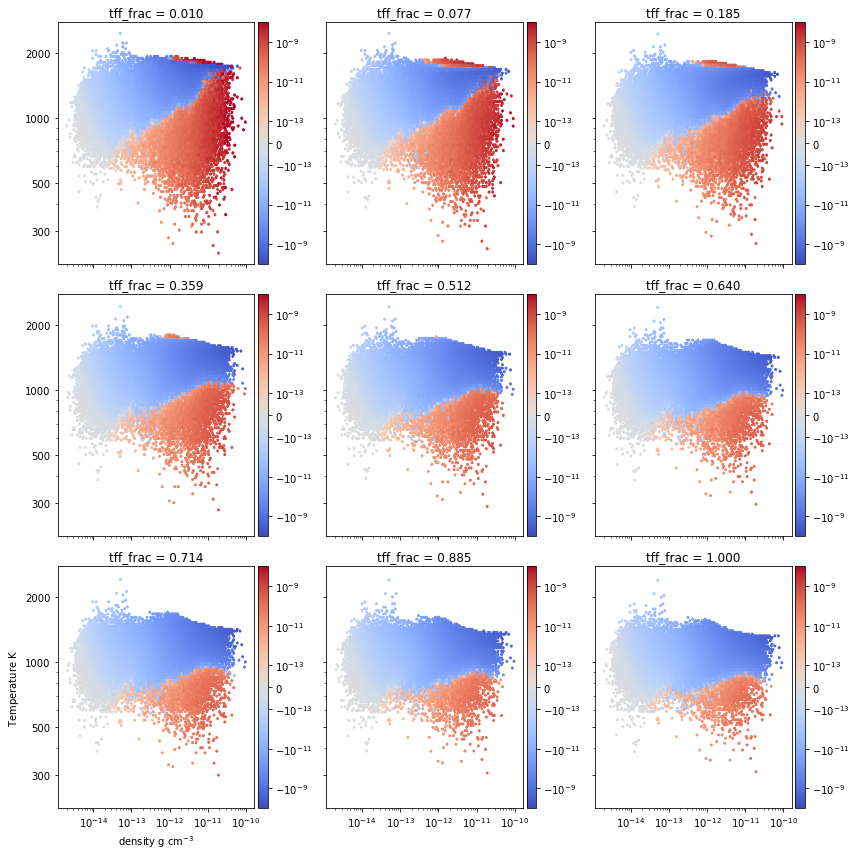

In [42]:
f, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

count = 0
for i in [0, 5, 10, 15, 18, 20, 21, 23, 25]:

    all_rates = calculate_instant_cooling_rates(rv_int, density, tidx=i)

    axes.flat[count].set_title(f"tff_frac = {rv_int['t'][i]/tff:.3f}")
    im = axes.flat[count].hexbin(
        density * 1.67e-24,
        all_rates["T"],
        all_rates["chemical"],
        norm=SymLogNorm(linthresh=1e-13, vmin=-1e-8, vmax=1e-8),
        cmap="coolwarm",
        xscale="log",
        yscale="log",
    )

    divider = make_axes_locatable(axes.flat[count])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im, cax=cax, orientation="vertical")

    if count == 6:
        axes.flat[count].set_xlabel("density $\mathrm{g ~ cm^{-3}}$")
        axes.flat[count].set_ylabel("Temperature $\mathrm{K}$")

    axes.flat[count].set_yticks([300, 500, 1000, 2000], labels=[300, 500, 1000, 2000])
    count += 1
plt.tight_layout()